In [5]:
import requests
from bs4 import BeautifulSoup


import asyncio
import os
import textwrap
from dataclasses import dataclass, field
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple

In [3]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [2]:
import requests, bs4, random, time

HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/123.0 Safari/537.36"
    ),
    "Accept-Language": "en-US,en;q=0.9",
    "Referer": "https://www.amazon.com/"
}

PRICE_SELECTORS = [
    {"name": "span", "attrs": {"id": "priceblock_ourprice"}},      # older
    {"name": "span", "attrs": {"id": "priceblock_dealprice"}},     # deals
    {"name": "span", "attrs": {"id": "price_inside_buybox"}},      # buy-box
    {"name": "span", "class_": "a-offscreen"},                     # generic
]

def get_amazon_price(url: str, retries: int = 3, backoff: float = 3.0):
    for attempt in range(1, retries + 1):
        r = requests.get(url, headers=HEADERS, timeout=15)
        if r.status_code != 200:
            print(f"[{attempt}/{retries}] HTTP {r.status_code}; retrying…")
            time.sleep(backoff * attempt + random.uniform(0, 2))
            continue

        soup = bs4.BeautifulSoup(r.text, "html.parser")

        # Try each known selector in turn
        for sel in PRICE_SELECTORS:
            tag = soup.find(**sel)
            if tag and tag.get_text(strip=True):
                return tag.get_text(strip=True)

        print(f"[{attempt}/{retries}] price not found; retrying…")
        time.sleep(backoff * attempt + random.uniform(0, 2))

    return None   # give up after `retries`
if __name__ == "__main__":
    url = ("https://www.amazon.com/Dell-Latitude-5400-i5-8265U-M-2-NVMe/dp/B0BG3GR52T/ref=sr_1_16?crid=2NXKNXMTP9CYD&dib=eyJ2IjoiMSJ9.BSvG7IZPCtKMId0idkEImQc88EVBBWxbh7eaJrmOYdhjsesnu8vXqCbw4l0SQLq4vKwBK9rYGbmFttRzGEkG1VFPWnklA9GKeFU3anW8dt98J8wYtexsm0m3DveZn4IxghEj2ouWWx00yqUiSS1MnbsSxre1MGZjLeM_x99h_RFxbsJSZBcLxYQE8ZkfZ5fDmAS-GubuITw4aLHOYNWHPAIDhbuBCKEzt_t07LiZ0V0.KvywiTaj66o41hRTyhSPi7Ut98-rTNSmtdUVQcB3fSs&dib_tag=se&keywords=dell+laptop&qid=1745715907&sprefix=dell+laptop%2Caps%2C111&sr=8-16")
    price = get_amazon_price(url)
    print("Current price:", price or "<not found>")


Current price: $260.00


In [8]:
from apify_client import ApifyClient

# Initialize the ApifyClient with your Apify API token
# Replace '<YOUR_API_TOKEN>' with your token.
client = ApifyClient("apify_api_LzSmJJKiHLwlXFwZ60Fe7dnLbvaMkD414k44")

# Prepare the Actor input
run_input = {
    "productUrls": [{ "url": "https://www.amazon.com/Dell-Latitude-5400-i5-8265U-M-2-NVMe/dp/B0BG3GR52T/ref=sr_1_16?crid=2NXKNXMTP9CYD&dib=eyJ2IjoiMSJ9.BSvG7IZPCtKMId0idkEImQc88EVBBWxbh7eaJrmOYdhjsesnu8vXqCbw4l0SQLq4vKwBK9rYGbmFttRzGEkG1VFPWnklA9GKeFU3anW8dt98J8wYtexsm0m3DveZn4IxghEj2ouWWx00yqUiSS1MnbsSxre1MGZjLeM_x99h_RFxbsJSZBcLxYQE8ZkfZ5fDmAS-GubuITw4aLHOYNWHPAIDhbuBCKEzt_t07LiZ0V0.KvywiTaj66o41hRTyhSPi7Ut98-rTNSmtdUVQcB3fSs&dib_tag=se&keywords=dell%2Blaptop&qid=1745715907&sprefix=dell%2Blaptop%2Caps%2C111&sr=8-16&th=1" }],
    "proxyCountry": "AUTO_SELECT_PROXY_COUNTRY",
}

# Run the Actor and wait for it to finish
run = client.actor("junglee/amazon-price-tracker").call(run_input=run_input)

# Fetch and print Actor results from the run's dataset (if there are any)
print("Check your data here: https://console.apify.com/storage/datasets/" + run["defaultDatasetId"])
for item in client.dataset(run["defaultDatasetId"]).iterate_items():
    print(item)


ModuleNotFoundError: No module named 'apify_client'

In [9]:
!pip install apify-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 3.4 MB/s eta 0:00:00


In [11]:
!pip install prophet
# Import the Prophet class
from prophet import Prophet

# Prepare data
df_prophet = df.rename(columns={"date": "ds", "price": "y"})

# Initialize model
model = Prophet(
    daily_seasonality=True,
    yearly_seasonality=False,
    weekly_seasonality=True  # allow Prophet to learn weekday effects
)
model.fit(df_prophet)

# Create future dataframe
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)


##price_forecast.csv is fetched from camelcamelcamel using the ASIN of the product.
# Save forecast


INFO:prophet:n_changepoints greater than number of observations. Using 10.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwox_ysip/cs4zo0mz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwox_ysip/owlsx6fb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78438', 'data', 'file=/tmp/tmpwox_ysip/cs4zo0mz.json', 'init=/tmp/tmpwox_ysip/owlsx6fb.json', 'output', 'file=/tmp/tmpwox_ysip/prophet_modelo_aq1bbu/prophet_model-20250427030728.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:07:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:07:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:n_changepoints greater than number of observations. Using 10.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwox_ysip/pfgznan5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwox_ysip/0d45a4m9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89289', 'data', 'file=/tmp/tmpwox_ysip/pfgznan5.json', 'init=/tmp/tmpwox_ysip/0d45a4m9.json', 'output', 'file=/tmp/tmpwox_ysip/prophet_modelmw65c17x/prophet_model-20250427030827.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:08:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:08:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Forecast saved as 'price_forecast.csv'!


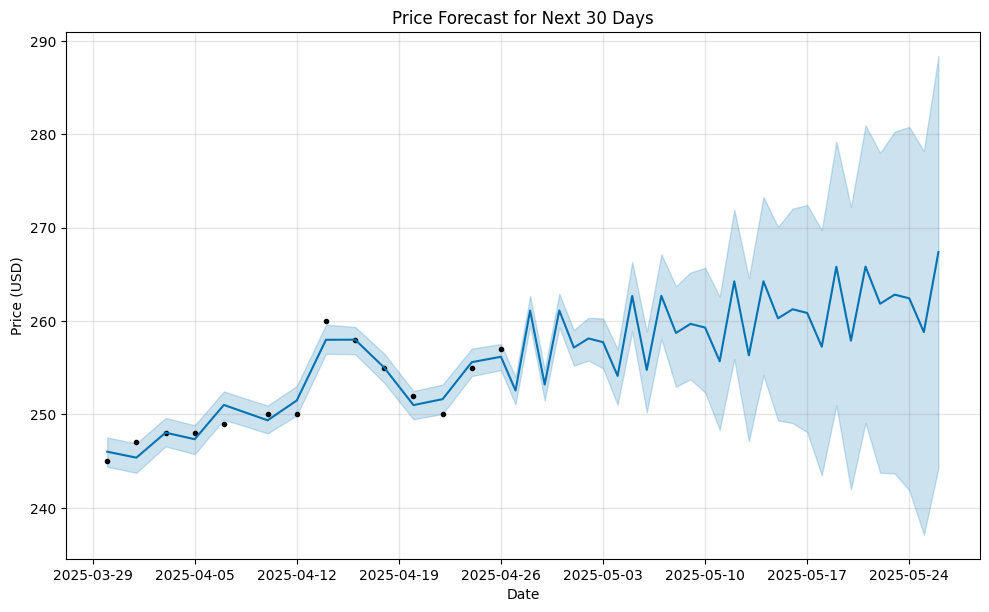

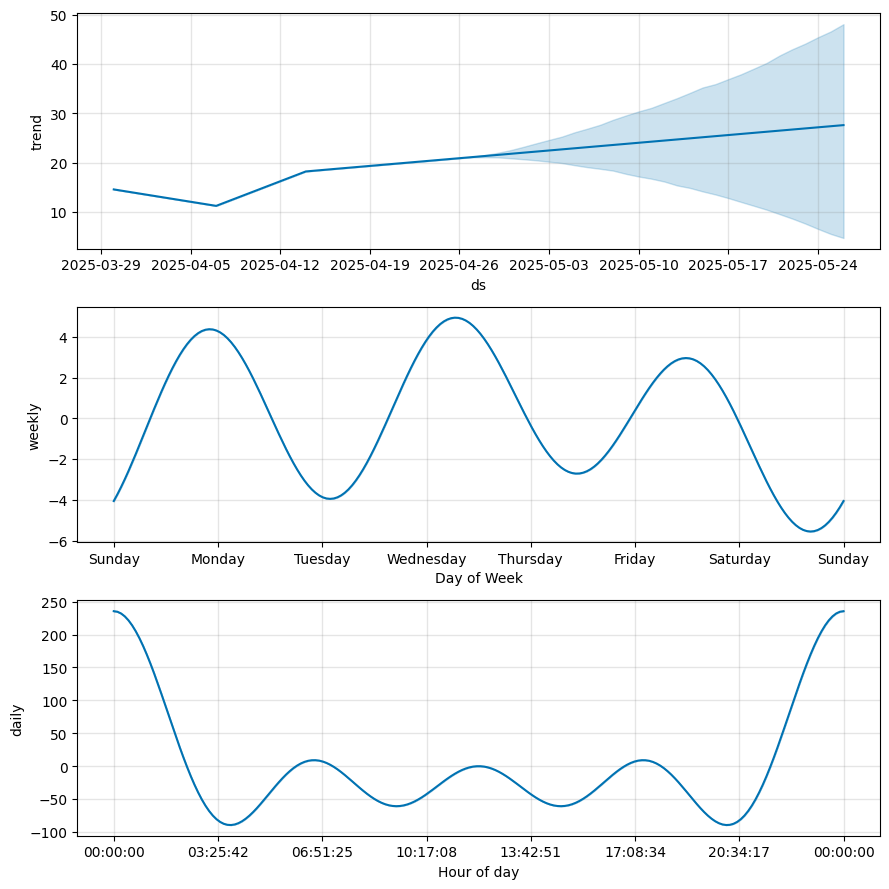

Lowest predicted price is $253.20 — No urgent alert.


In [12]:
# Prepare data
import matplotlib.pyplot as plt
df_prophet = df.rename(columns={"date": "ds", "price": "y"})

# Initialize model
model = Prophet(
    daily_seasonality=True,
    yearly_seasonality=False,
    weekly_seasonality=True  # allow Prophet to learn weekday effects
)
model.fit(df_prophet)

# Create future dataframe
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)


##price_forecast.csv is fetched from camelcamelcamel using the ASIN of the product.
# Save forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("price_forecast.csv", index=False)
print("Forecast saved as 'price_forecast.csv'!")

# --------- Step 3: Plot the forecast and weekday effects ---------

# Plot price forecast
fig1 = model.plot(forecast)
plt.title("Price Forecast for Next 30 Days")
plt.ylabel("Price (USD)")
plt.xlabel("Date")
plt.show()

# Plot weekday (weekly seasonality) effect separately
fig2 = model.plot_components(forecast)
plt.show()

# In the components plot:
# - Weekly seasonality will show if, for example, prices drop more on Sundays/Mondays.

# --------- Step 4: Alert if future price prediction < $240 ---------

future_low = forecast[forecast['ds'] >= pd.to_datetime('today')]
cheapest_day = future_low.loc[future_low['yhat'].idxmin()]
cheap_price = cheapest_day['yhat']
cheap_date = cheapest_day['ds']

if cheap_price < 240:
    print(f"ALERT: Expected low price ${cheap_price:.2f} on {cheap_date.date()} — Good time to BUY!")
else:
    print(f"Lowest predicted price is ${cheap_price:.2f} — No urgent alert.")